We want to understand the time dependence of the data. To do so, we try to use Gaussian Processes from GPFlow, which is powered by TensorFlow.

In [1]:
# import libs && tools
import numpy as np
import pandas as pd
import gpflow
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,6)
plt = matplotlib.pyplot

W0617 15:37:31.078895  3212 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\gpflow\session_manager.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0617 15:37:31.078895  3212 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\gpflow\misc.py:25: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0617 15:37:31.198998  3212 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\gpflow\saver\coders.py:80: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.



In [2]:
# import and handle data
df = pd.read_csv('../data/20190606180000-20190606190000.csv')
df=df.replace([np.inf, -np.inf], np.nan)
df=df.dropna();
df=df.round(decimals=5)  # round to one decimal after precision of devices
df['diff'] = (df['B_VIMIN'] - df['B:VIMIN'])
df2= pd.DataFrame({'diff' : df['diff'], 'err' : df['B:IMINER']})
col1,col2,col3='B:IMINER','B:VIMIN','B_VIMIN'

C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (77,79,81,83,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# define period of TLG
horizon = 61.4; # unit: sec. horizon of TLG..61.-- sec
cycle   = 15; # 15Hz sampling
supercycle = int(cycle*horizon);

num_train = 1*supercycle

In [4]:
np.random.seed(1)
X = np.random.rand(num_train,1) 
#X[:][0] = df[col1][:num_train].values
X[:,0] =  df[col1][:num_train].values

Text(0, 0.5, 'observed data value')

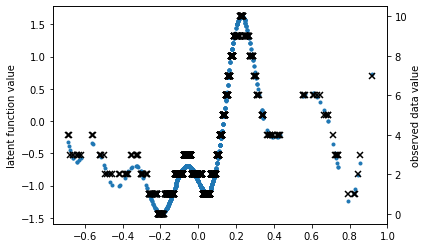

In [5]:
n = len(X)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(n)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(n, 1))

plt.plot(X, f, '.')
plt.ylabel('latent function value')

Y = np.round((f + f.min())*3)
Y = Y - Y.min()
Y = np.asarray(Y, np.float64)


plt.twinx()
plt.plot(X, Y, 'kx', mew=1.5)
plt.ylabel('observed data value')

In [6]:
# construct ordinal likelihood
bin_edges = np.array(np.arange(np.unique(Y).size + 1), dtype=float)
bin_edges = bin_edges - bin_edges.mean()
likelihood=gpflow.likelihoods.Ordinal(bin_edges)

# build a model with this likelihood
m = gpflow.models.VGP(X, Y,
                   kern=gpflow.kernels.Matern32(1),
                   likelihood=likelihood)

#fit the model
gpflow.train.ScipyOptimizer().minimize(m)

W0617 15:37:34.945101  3212 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\gpflow\core\node.py:109: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 15:37:34.973243  3212 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\gpflow\params\parameter.py:385: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 15:37:34.973243  3212 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\gpflow\params\parameter.py:391: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0617 15:37:37.444379  3212 deprecation.py:323] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\tensorflow\python\ops\array_grad.py:199: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instr

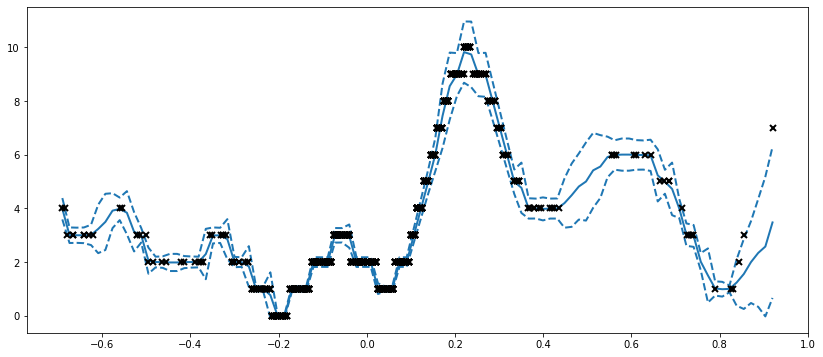

In [7]:
plt.figure(figsize=(14, 6))
Xtest = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 100).reshape(-1, 1)
mu, var = m.predict_y(Xtest)
line, = plt.plot(Xtest, mu, lw=2)
col=line.get_color()
plt.plot(Xtest, mu+2*np.sqrt(var), '--', lw=2, color=col)
plt.plot(Xtest, mu-2*np.sqrt(var), '--', lw=2, color=col)
plt.plot(m.X.read_value(), m.Y.read_value(), 'kx', mew=2)

In [8]:
err_linf = np.linalg.norm( m.Y.read_value() - Xtest)

ValueError: operands could not be broadcast together with shapes (921,1) (100,1) 

In [ ]:
# to see the predictive density, try predicting every possible value.
def pred_density(m):
    Xtest = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 100).reshape(-1, 1)
    ys = np.arange(m.Y.read_value().max()+1)
    densities = []
    for y in ys:
        Ytest = np.ones_like(Xtest) * y
        densities.append(m.predict_density(Xtest, Ytest))
    return np.hstack(densities).T

In [ ]:
plt.imshow(np.exp(pred_density(m)), interpolation='nearest',
           extent=[m.X.read_value().min(), m.X.read_value().max(), -0.5, m.Y.read_value().max()+0.5],
           origin='lower', aspect='auto', cmap=plt.cm.viridis)
plt.colorbar()
plt.plot(X, Y, 'kx', mew=2, scalex=False, scaley=False)